### Import and View Data

In [1]:
import pandas as pd 
import numpy as np
import os
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# enabling validation split
validation_mode = False

# ensure the file path is set to where the nytaxi2022.csv file is located
data = pd.read_csv('./RawData/nytaxi2022.csv')

In [4]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,01/01/2022 12:35:40 AM,01/01/2022 12:53:29 AM,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,01/01/2022 12:33:43 AM,01/01/2022 12:42:07 AM,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,01/01/2022 12:53:21 AM,01/01/2022 01:02:19 AM,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,01/01/2022 12:25:21 AM,01/01/2022 12:35:23 AM,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,01/01/2022 12:36:48 AM,01/01/2022 01:14:20 AM,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39656098 entries, 0 to 39656097
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: float64(12), int64(4), object(3)
memory usage: 5.6+ GB


### Drop NAs and extract relevant columns

In [6]:
# extract relevant columns and drop na values 
features = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 
            'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'extra']
target = 'total_amount'

# drop na values in these columns
df_clean = data[features + [target]].dropna()

In [7]:
# number of rows in the cleaned dataframe
df_clean.shape[0]

38287795

### Preprocess datetime columns

In [8]:
## convert date columns into datetime data type 
pickup_format = '%m/%d/%Y %I:%M:%S %p'  # %I = 12-hour, %p = AM/PM

df_clean['tpep_pickup_datetime'] = pd.to_datetime(df_clean['tpep_pickup_datetime'], format=pickup_format)
df_clean['tpep_dropoff_datetime'] = pd.to_datetime(df_clean['tpep_dropoff_datetime'], format=pickup_format)

In [9]:
# verify 
df_clean.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,extra,total_amount
0,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,142,236,1,3.0,21.95
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,236,42,1,0.5,13.30
2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,166,166,1,0.5,10.56
3,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,114,68,2,0.5,11.80
4,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,68,163,1,0.5,30.30


In [10]:
df_clean.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
extra                           float64
total_amount                    float64
dtype: object

In [11]:
# Extract useful (numerical) features from datetime columns
df_clean['pickup_hour'] = df_clean['tpep_pickup_datetime'].dt.hour
df_clean['pickup_minute'] = df_clean['tpep_pickup_datetime'].dt.minute
df_clean['pickup_dayofweek'] = df_clean['tpep_pickup_datetime'].dt.dayofweek
df_clean['dropoff_hour'] = df_clean['tpep_dropoff_datetime'].dt.hour
df_clean['dropoff_minute'] = df_clean['tpep_dropoff_datetime'].dt.minute
df_clean['dropoff_dayofweek'] = df_clean['tpep_dropoff_datetime'].dt.dayofweek

# Trip duration in minutes
df_clean['trip_duration'] = (df_clean['tpep_dropoff_datetime'] - df_clean['tpep_pickup_datetime']).dt.total_seconds() / 60

We won't be needing columns `tpep_pickup_datetime` and `tpep_dropoff_datetime`. They won't be included in the final X set

In [12]:
df_clean.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)

In [13]:
df_clean.head()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,extra,total_amount,pickup_hour,pickup_minute,pickup_dayofweek,dropoff_hour,dropoff_minute,dropoff_dayofweek,trip_duration
0,2.0,3.80,1.0,142,236,1,3.0,21.95,0,35,5,0,53,5,17.816667
1,1.0,2.10,1.0,236,42,1,0.5,13.30,0,33,5,0,42,5,8.400000
2,1.0,0.97,1.0,166,166,1,0.5,10.56,0,53,5,1,2,5,8.966667
3,1.0,1.09,1.0,114,68,2,0.5,11.80,0,25,5,0,35,5,10.033333
4,1.0,4.30,1.0,68,163,1,0.5,30.30,0,36,5,1,14,5,37.533333


### Check Range of Values

The range of values of the target variable  `total_amount` is investigated. 

Text(0, 0.5, 'Frequency')

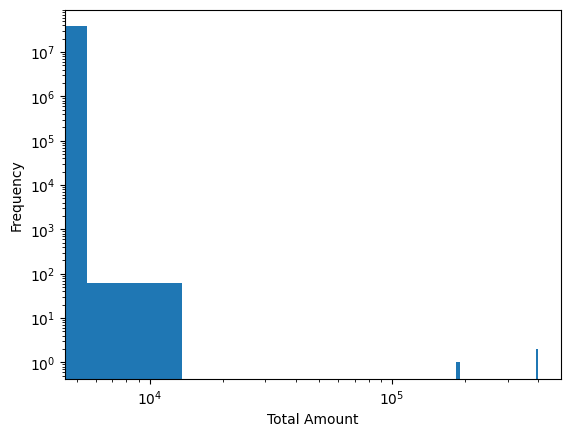

In [14]:
# plot histogram of target variable
plt.hist(df_clean['total_amount'], bins=50)
# log scaling
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')

In [15]:
df_clean['total_amount'].describe()

count    3.828780e+07
mean     2.142373e+01
std      9.801355e+01
min     -2.567800e+03
25%      1.230000e+01
50%      1.595000e+01
75%      2.277000e+01
max      4.010956e+05
Name: total_amount, dtype: float64

Most total taxi fares are a few hundred dollars. However, there are some negative values as well as some extremely high values. We will investigate these two separately. 

#### Investigate negative values

In [16]:
df_clean[df_clean['total_amount'] < 0]

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,extra,total_amount,pickup_hour,pickup_minute,pickup_dayofweek,dropoff_hour,dropoff_minute,dropoff_dayofweek,trip_duration
154,1.0,7.38,1.0,132,265,4,-0.5,-23.55,0,26,5,0,39,5,12.966667
521,1.0,5.14,1.0,152,48,4,-0.5,-20.80,0,27,5,0,40,5,13.533333
523,4.0,5.37,5.0,50,265,2,0.0,-77.80,0,59,5,1,14,5,14.600000
580,1.0,0.46,1.0,90,234,2,-0.5,-7.80,0,16,5,0,19,5,2.716667
714,1.0,3.13,1.0,13,246,4,-0.5,-15.80,0,29,5,0,40,5,11.283333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39529352,1.0,2.27,1.0,107,237,2,-1.0,-19.90,23,4,5,23,17,5,12.733333
39529420,1.0,0.03,1.0,132,132,4,-1.0,-13.75,23,9,5,23,19,5,10.133333
39529511,1.0,0.53,1.0,243,243,3,-1.0,-8.30,23,3,5,23,7,5,4.416667
39529513,2.0,3.34,1.0,235,235,3,-1.0,-27.90,23,37,5,0,4,6,26.900000


In [17]:
# print rows where total_amount is negative but extra is positive
df_clean[(df_clean['total_amount'] < 0) & (df_clean['extra'] > 0)]

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,extra,total_amount,pickup_hour,pickup_minute,pickup_dayofweek,dropoff_hour,dropoff_minute,dropoff_dayofweek,trip_duration


In [18]:
# print rows where total_amount is negative but extra is zero
df_clean[(df_clean['total_amount'] < 0) & (df_clean['extra'] == 0)]

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,extra,total_amount,pickup_hour,pickup_minute,pickup_dayofweek,dropoff_hour,dropoff_minute,dropoff_dayofweek,trip_duration
523,4.0,5.37,5.0,50,265,2,0.0,-77.80,0,59,5,1,14,5,14.600000
3649,1.0,0.00,5.0,264,264,4,0.0,-10.30,0,9,5,0,9,5,0.033333
5730,1.0,0.01,5.0,163,163,4,0.0,-17.71,1,49,5,1,50,5,0.716667
6527,2.0,0.02,2.0,234,234,2,0.0,-55.30,1,10,5,1,11,5,0.116667
8815,1.0,0.19,5.0,265,265,4,0.0,-92.30,2,34,5,2,35,5,0.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39524584,1.0,0.02,5.0,144,144,2,0.0,-30.64,22,10,5,22,12,5,1.800000
39525518,2.0,0.00,2.0,164,164,4,0.0,-74.00,22,59,5,22,59,5,0.100000
39525984,2.0,0.00,2.0,234,234,4,0.0,-74.00,22,13,5,22,13,5,0.100000
39525997,2.0,0.16,5.0,137,137,4,0.0,-22.44,22,38,5,22,38,5,0.766667


In [19]:
# proportion of rows that have negative values
df_clean[df_clean['total_amount'] < 0].shape[0] / df_clean.shape[0]

0.006660634283065923

Negative values are rare and kept since they may refer to scenarios requiring refunds/fare adjustments. Furthermore, they make up for less than 1% of the dataset. 

Next, we investigate rows with extremely large fares. 

In [20]:
# print rows where total_amount is greater than 10000
df_clean[df_clean['total_amount'] > 10000]

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,extra,total_amount,pickup_hour,pickup_minute,pickup_dayofweek,dropoff_hour,dropoff_minute,dropoff_dayofweek,trip_duration
429860,1.0,3.30,1.0,107,140,4,2.5,401095.62,11,36,4,11,47,4,10.483333
17467531,3.0,1.20,1.0,163,140,3,2.5,395848.24,9,47,5,9,55,5,8.100000
28512133,0.0,3.50,1.0,233,232,4,2.5,187448.26,17,49,5,17,59,5,9.583333
28752820,1.0,34.42,1.0,138,138,2,2.5,10003.29,8,50,1,9,36,1,46.416667


There are 3 values greater than 10,000 which clearly have a shorter trip distance and duration but has exorbitant total amounts. These could potentially be anomalies and thus best removed since they would also skew RMSE values in the training & evaluation phase. 

In [21]:
df_clean = df_clean[df_clean['total_amount'] <= 10000]

In [22]:
# print rows where total_amount is greater than 10000
df_clean[df_clean['total_amount'] > 10000]

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,extra,total_amount,pickup_hour,pickup_minute,pickup_dayofweek,dropoff_hour,dropoff_minute,dropoff_dayofweek,trip_duration


In [23]:
df_clean['total_amount'].describe()

count    3.828779e+07
mean     2.139776e+01
std      1.982601e+01
min     -2.567800e+03
25%      1.230000e+01
50%      1.595000e+01
75%      2.277000e+01
max      7.060850e+03
Name: total_amount, dtype: float64

Other large values are kept since it could reflect realistic scenarios. Furthermore, for trips with values above $1000 indeed have trip distances/duration seem to be large. 

### Split into Train, Valid, Test

The dataset is split into train-valid-test in the following proportion 60-10-30. 

In [24]:
random_state = 37 
if validation_mode:
    train_valid, test = train_test_split(df_clean, test_size=0.3, random_state=random_state)
    train, valid = train_test_split(train_valid, test_size=0.1429, random_state=random_state) # 0.1429 * 0.7 = 0.1
    print(f"Train shape: {train.shape}, Valid shape: {valid.shape}, Test shape: {test.shape}")
else:
    train, test = train_test_split(df_clean, test_size=0.3, random_state=random_state)
    print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (26801453, 15), Test shape: (11486338, 15)


### Standardization  

Convert all data points to a standard scale of [0, 1]

In [25]:
# Scale features using MinMaxScaler fit on train only, excluding the target column
X_cols = [c for c in train.columns if c != target]

x_scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(x_scaler.fit_transform(train[X_cols]), columns=X_cols, index=train.index)
X_test_scaled  = pd.DataFrame(x_scaler.transform(test[X_cols]),  columns=X_cols, index=test.index)

y_train = train[[target]]
y_test  = test[[target]]

if validation_mode:
    X_valid_scaled = pd.DataFrame(x_scaler.transform(valid[X_cols]), columns=X_cols, index=valid.index)
    y_valid = valid[[target]]

In [26]:
# print lengths of all datasets
print(f"X_train: {X_train_scaled.shape}, y_train: {y_train.shape}")
if validation_mode:
    print(f"X_valid: {X_valid_scaled.shape}, y_valid: {y_valid.shape}")
print(f"X_test: {X_test_scaled.shape}, y_test: {y_test.shape}")

X_train: (26801453, 14), y_train: (26801453, 1)
X_test: (11486338, 14), y_test: (11486338, 1)


### Save the Splitted & Cleaned Data: For In-Memory Sharding Implementation

In [26]:
X_train_scaled = X_train_scaled.values.astype(np.float32)
X_test_scaled = X_test_scaled.values.astype(np.float32)
y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

np.save('./Data/X_train.npy', X_train_scaled)
np.save('./Data/X_test.npy', X_test_scaled)
np.save('./Data/y_train.npy', y_train)
np.save('./Data/y_test.npy', y_test)

if validation_mode:
    X_valid_scaled = X_valid_scaled.values.astype(np.float32)
    y_valid = y_valid.values.astype(np.float32)
    np.save('./Data/X_valid.npy', X_valid_scaled)
    np.save('./Data/y_valid.npy', y_valid)


### Split the Entire Dataset and save them into Smaller Blocks

In [27]:
split_batch_size = 2048
X_train_dir = "Data_Split/X_train"
y_train_dir = "Data_Split/y_train"
X_val_dir = "Data_Split/X_valid"
y_val_dir = "Data_Split/y_valid"
X_test_dir = "Data_Split/X_test"
y_test_dir = "Data_Split/y_test"

### Process Batch Split for Memory Efficient Sharing

#### Process Batch Split: Train

In [31]:
os.makedirs(X_train_dir, exist_ok = True)
os.makedirs(y_train_dir, exist_ok = True)

for i in tqdm.tqdm(range(len(X_train_scaled) // split_batch_size + 1)):
    X_batch, y_batch = X_train_scaled[i*split_batch_size:(i+1)*split_batch_size], y_train[i*split_batch_size:(i+1)*split_batch_size]
    if len(X_batch) == 0:
        continue
    save_X = f"{X_train_dir}/trainX_batch_{i}.npy"
    save_y = f"{y_train_dir}/trainy_batch_{i}.npy"
    np.save(save_X, X_batch)
    np.save(save_y, y_batch)

100%|██████████| 13087/13087 [00:12<00:00, 1012.14it/s]


#### Process Batch Split: Test

In [32]:
os.makedirs(X_test_dir, exist_ok = True)
os.makedirs(y_test_dir, exist_ok = True)

for i in tqdm.tqdm(range(len(X_test_scaled) // split_batch_size + 1)):
    X_batch, y_batch = X_test_scaled[i*split_batch_size:(i+1)*split_batch_size], y_test[i*split_batch_size:(i+1)*split_batch_size]
    if len(X_batch) == 0:
        continue
    save_X = f"{X_test_dir}/testX_batch_{i}.npy"
    save_y = f"{y_test_dir}/testy_batch_{i}.npy"
    np.save(save_X, X_batch)
    np.save(save_y, y_batch)

100%|██████████| 5609/5609 [00:05<00:00, 1056.36it/s]


#### Process Batch Split: Validation (If Enabled)

In [30]:
if validation_mode:
    os.makedirs(X_val_dir, exist_ok = True)
    os.makedirs(y_val_dir, exist_ok = True)

    for i in tqdm.tqdm(range(len(X_valid_scaled) // split_batch_size + 1)):
        X_batch, y_batch = X_valid_scaled[i*split_batch_size:(i+1)*split_batch_size], y_valid[i*split_batch_size:(i+1)*split_batch_size]
        if len(X_batch) == 0:
            continue
        save_X = f"{X_val_dir}/valX_batch_{i}.npy"
        save_y = f"{y_val_dir}/valy_batch_{i}.npy"
        np.save(save_X, X_batch)
        np.save(save_y, y_batch)